** Experiment - 6 **

1. Create OHE feature for genres
2. Count features for ( Num cities, Num genres, Num titles, Num tod, Num dow )
3. Feature for watch time ( Watch Time by genre )
4. Create a xgboost model
5. Print out feature importance and feature interaction
6. Tune Model.

In [28]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import gc
import time

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

%run ../src/data/HotstarDataset.py
%run ../src/features/categorical_features.py
%run ../src/features/util.py
%run ../src/models/cross_validation.py

SEED = 12313
np.random.seed(SEED)

In [29]:
del xgdd

In [2]:
dataset = Hotstar('../data/raw/5f828822-4--4-hotstar_dataset/')
dataset.load_data('../data/processed/hotstar_processed.feather')

data_processed = dataset.data
train_mask     = dataset.get_train_mask() 

In [5]:
# ohe genres
genres_ohe_encoded = encode_ohe(data_processed.genres)

In [9]:
# count based features

data_processed['num_cities'] = count_feature(data_processed.cities)
data_processed['num_genres'] = count_feature(data_processed.genres)
data_processed['num_titles'] = count_feature(data_processed.titles)
data_processed['num_tod']    = count_feature(data_processed.tod)
data_processed['num_dow']    = count_feature(data_processed.dow)

In [10]:
# watch time by genres
data_processed['watch_time_sec'] = num_seconds_watched(data_processed.genres)

In [14]:
features = pd.concat((data_processed[['num_cities', 'num_genres',
                'num_titles', 'num_tod',
                'num_dow', 'watch_time_sec',
                'segment'
               ]], genres_ohe_encoded), axis='columns')

save_file(features, '../data/processed/hotstar_processed_1.feather')

** Train and Test Split **

In [23]:
X = features.loc[train_mask, features.columns.drop('segment')]
y = features.loc[train_mask, 'segment']
Xtest = features.loc[~train_mask, features.columns.drop('segment')]

In [24]:
params = {
    'stratify': y,
    'test_size': .3,
    'random_state': SEED
}

X_train, X_test, y_train, y_test = get_train_test_split(X, y, **params)

In [31]:
# further split train set into train and validation set
params = {
    'stratify': y_train,
    'test_size': .2,
    'random_state': SEED
}

Xtr, Xte, ytr, yte = get_train_test_split(X_train, y_train, **params)

In [36]:
dtrain = xgb.DMatrix(Xtr, ytr, missing=np.nan, feature_names=features.columns.drop('segment'))
dval   = xgb.DMatrix(Xte, yte, missing=np.nan, feature_names=features.columns.drop('segment'))

xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'gamma': 1,
    'colsample_bytree': 1.,
    'min_child_weight': 10,
    'subsample': 1.,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': SEED,
    'silent': 1
}

n_estimators = 120

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=n_estimators, verbose_eval=10,
                  evals=watchlist
                 )

[0]	train-auc:0.766258	val-auc:0.775591
[10]	train-auc:0.78031	val-auc:0.786849
[20]	train-auc:0.785043	val-auc:0.79127
[30]	train-auc:0.790028	val-auc:0.794607
[40]	train-auc:0.794624	val-auc:0.798239
[50]	train-auc:0.797991	val-auc:0.800191
[60]	train-auc:0.800029	val-auc:0.801088
[70]	train-auc:0.801597	val-auc:0.801593
[80]	train-auc:0.803262	val-auc:0.802013
[90]	train-auc:0.80449	val-auc:0.802211
[100]	train-auc:0.805712	val-auc:0.802262
[110]	train-auc:0.806949	val-auc:0.802467


** Feature Imporatance **

In [37]:
scores = model.get_score(importance_type='gain')
sorted(scores.items(), key=lambda x: -x[1])

[('Cricket', 373.5899093650793),
 ('Family', 35.90457671641791),
 ('num_dow', 30.53529867469879),
 ('LiveTV', 28.951437499999997),
 ('Romance', 28.130577638888887),
 ('num_tod', 27.74805718120805),
 ('TalkShow', 22.997877528089887),
 ('Action', 22.99130448979592),
 ('Drama', 21.95580166666667),
 ('Football', 13.84148136363636),
 ('num_cities', 12.815120236111113),
 ('Crime', 12.016978260869564),
 ('Mythology', 11.715943846153843),
 ('num_titles', 11.405313466135471),
 ('Sport', 10.66834785714286),
 ('watch_time_sec', 9.61585368864469),
 ('Comedy', 9.210640624999998),
 ('Kids', 8.4128216),
 ('Awards', 8.053647647058824),
 ('Travel', 7.952873846153848),
 ('Teen', 6.1760850000000005),
 ('Thriller', 5.750470000000001),
 ('num_genres', 5.588814385964912),
 ('Science', 5.449479),
 ('Horror', 5.0525139999999995),
 ('Badminton', 4.6202000000000005),
 ('Wildlife', 4.3635842857142855),
 ('Reality', 3.9744425),
 ('Hockey', 3.6322525)]

** Test score on test set **

In [40]:
dtrain = xgb.DMatrix(X_train, y_train, missing=np.nan, feature_names=features.columns.drop('segment'))
dtest  = xgb.DMatrix(X_test, y_test, missing=np.nan, feature_names=features.columns.drop('segment'))

model = xgb.train(xgb_params, dtrain=dtrain, num_boost_round=150)
preds = model.predict(dtest)

print('AUC score: {}'.format(roc_auc_score(y_test, preds)))

AUC score: 0.8035808150942052


** Full Training **

In [42]:
dtrain = xgb.DMatrix(X, y, missing=np.nan, feature_names=features.columns.drop('segment'))
dtest  = xgb.DMatrix(Xtest, missing=np.nan, feature_names=features.columns.drop('segment'))

model = xgb.train(xgb_params, dtrain, num_boost_round=150)
preds = model.predict(dtest)

** Plot Prediction Probabilities that would serve as ranks **

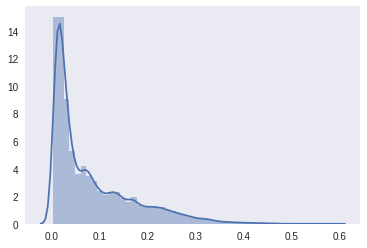

In [43]:
sns.distplot(preds);

In [47]:
data_processed.loc[~train_mask, 'ID'].head(10)

200000         test-1
200001        test-10
200002       test-100
200003      test-1000
200004     test-10000
200005    test-100000
200006     test-10001
200007     test-10002
200008     test-10003
200009     test-10004
Name: ID, dtype: object

In [48]:
sub

,ID,segment
0,test-23855,0.023505
1,test-23854,0.054431
2,test-23857,0.206844
3,test-23856,0.154665
4,test-23851,0.130384
5,test-23850,0.077402
6,test-23853,0.040778
7,test-23852,0.073175
8,test-23859,0.008348
9,test-23858,0.031081


In [56]:
sub            = pd.read_csv('../data/raw/5f828822-4--4-hotstar_dataset/sample_submission.csv')
sub['segment'] = preds
sub['ID']      = data_processed.loc[~train_mask, 'ID'].values
sub.to_csv('../submissions/hotstar/xgb_processed_dataset_1.csv', index=False)